# Face Recognition using Siamese Network

### Install and Import Dependencies

In [ ]:
# Install dependencies
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [1]:
# Import dependencies
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, Input, Flatten, MaxPooling2D

### Set GPU Growth

In [3]:
# Avoid OOM (Out of Memory) errors by setting GPU Memory Consumption Growth
# GPU stands for Graphical Processing Unit
# gpus = tf.config.list_physical_devices('GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Number of physical devices in the machine
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [5]:
# Number of CPU's in the machine
cpus = tf.config.list_physical_devices('CPU')
len(cpus)

1

In [6]:
# Printing the number of CPU's in the machine
for cpu in cpus:
    print(cpu)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [7]:
# Number of GPU's in the machine
len(gpus)

0

In [8]:
# Printing the GPU's in the machine
for gpu in gpus:
    print(gpu)

### Create Folder Structures

In [9]:
# POS_PATH for positive image path which has the correct images
POS_PATH = os.path.join('data', 'positive')

# NEG_PATH for negative image path which has incorrect images
NEG_PATH = os.path.join('data', 'negative')

# ANC_PATH for anchor image path which has the image to be tested against negative and positive images
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
# 'makedirs' makes the directory from scratch that is it creates all the intermediate directories
# Like in this example it will create 'data' directory under which 'positive' directory whould be made
# So the complete path using 'makedirs' will look like 'data\positive\'
# Whereas 'mkdir' creates single sub-directory that is,
# it would make just the 'positive' directory and not its super directory 'data'
# The complete path using 'mkdir' would look like 'positive\'
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [10]:
# Printing the path
print(POS_PATH)
print(NEG_PATH)
print(ANC_PATH)

data\positive
data\negative
data\anchor


### Collect Negatives from Labelled Faces in the Wild Dataset

In [ ]:
# Link to labelled faces in the wild dataset (Negative Input) : http://vis-www.cs.umass.edu/lfw/#download
# Uncompress Tar GZ labelled faces in the wild dataset
!tar -xf lfw.tgz

In [ ]:
# Move 'lfw' images to 'data\Negative'
# The first two lines of code generates the entire set of images from each files in each directory
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        
#         EX_PATH for existing path of the labelled images in the wild dataset
        EX_PATH = os.path.join('lfw', directory, file)
        
#         NEW_PATH for the path of 'Negative' directory in 'data' directory
        NEW_PATH = os.path.join(NEG_PATH, file)
        
#         Moving all labelled images into NEW_PATH
        os.replace(EX_PATH, NEW_PATH)

### Collect Positives and Anchors using Webcam

In [11]:
# Import uuid library to generate unique names to each image
# uuid stands for Univerally Unique IDentifier
import uuid

In [12]:
# Generation of unique filename via different forms
print('{}.jpg'.format(uuid.uuid1()))
print('{}.jpg'.format(uuid.uuid4()))

# Just to check how the unique filename is generated using 'uuid' along with the path
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

6e648398-38e5-11ee-9ba4-f75f2ef10444.jpg
31df9122-458a-4cff-9a23-51a4bb6bb9aa.jpg


'data\\anchor\\6e648399-38e5-11ee-8026-f75f2ef10444.jpg'

In [13]:
# Establish a connection to the Webcam
# Here, '0' is the device's webcam's location
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
#     Cut down frame to 250x250px
    frame = frame[170:170+250, 220:220+250, :]
    
#     Collect anchor images
#     On clicking 'a' on keyboard an anchor image would be created and stored in the desired directory
    if cv2.waitKey(1) & 0xFF == ord('a'):
#         Create the unique anchor image file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
#         Store the image in respective directory (Write out anchor image)
        cv2.imwrite(imgname, frame)
    
#     Collect positive images
#     On clicking 'p' on keyboard a positive image would be created and stored in the desired directory
    if cv2.waitKey(1) & 0xFF == ord('p'):
#         Create the unique positive image file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
#         Store the image in respective directory (Write out positive image)
        cv2.imwrite(imgname, frame)
    
#     Show Image back to screen
    cv2.imshow("Image Collection", frame)
    
#     Breaking gracefully
#     On clicking 'q' on keyboard, the looping would break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
# Release the Webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

(250, 250, 3)


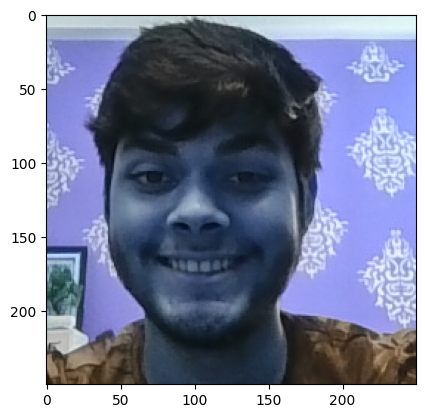

In [14]:
# Print the frame shape
print(frame.shape)
plt.imshow(frame)
plt.show()
# Image slicing
# print(frame[170:170+250, 220:220+250, :].shape)
# plt.imshow(frame[170:170+250, 220:220+250, :])
# plt.show()
# print(frame[250:250+250, 120:120+250, :].shape)
# plt.imshow(frame[250:250+250, 120:120+250, :])
# plt.show()

### Get Image Directories

In [15]:
# Getting the image file path from each directory
anchor = tf.data.Dataset.list_files(ANC_PATH + '\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '\*.jpg').take(300)

In [16]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data\\anchor\\66b0f725-37ad-11ee-823f-346f24d0c492.jpg'


### Pre-Processing (Scale and Resize)

In [17]:
def preprocess(file_path):
    
#     Read the image from image file path
    byte_img = tf.io.read_file(file_path)
    
#     Load the image
    img = tf.io.decode_jpeg(byte_img)
    
#     Resize the image to 100x100x3
    img = tf.image.resize(img, (100, 100))
    
#     Scale the image to be between 0 and 1
    img = img / 255.0
    
#     Return the image
    return img

In [18]:
# Testing the above file path
img = preprocess('data\\anchor\\646f7b8b-37ad-11ee-a12c-346f24d0c492.jpg')

In [19]:
# Getting details of the image
img

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.9647059 , 0.972549  , 0.9529412 ],
        [0.96568626, 0.97745097, 0.95      ],
        [0.96568626, 0.97745097, 0.95      ],
        ...,
        [0.72990197, 0.714951  , 0.6811274 ],
        [0.69534314, 0.66862744, 0.63553923],
        [0.6664216 , 0.63308823, 0.59681374]],

       [[0.96642154, 0.97818625, 0.9507353 ],
        [0.9647059 , 0.9764706 , 0.9490196 ],
        [0.96544117, 0.9772059 , 0.9497549 ],
        ...,
        [0.6965686 , 0.65931374, 0.6161765 ],
        [0.70759803, 0.65563726, 0.61838233],
        [0.7134804 , 0.6546569 , 0.6164216 ]],

       [[0.9647059 , 0.9764706 , 0.9490196 ],
        [0.9647059 , 0.9764706 , 0.9490196 ],
        [0.96617645, 0.97794116, 0.9504902 ],
        ...,
        [0.73284316, 0.6512255 , 0.60906863],
        [0.73137254, 0.6431373 , 0.59607846],
        [0.747549  , 0.65539217, 0.6093137 ]],

       ...,

       [[0.87965685, 0.8926471 , 0.8401961 ],
        [0.88

In [20]:
# Printing the minimum and maximum pixel value in image
print(img.numpy().min())
print(img.numpy().max())

0.0
1.0


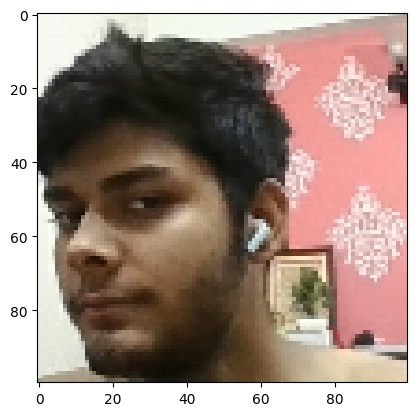

In [21]:
plt.imshow(img)

In [22]:
# dataset.map(preprocess)

### Create Labelled Dataset

In [23]:
tf.ones(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [24]:
tf.zeros(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [25]:
tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.float32, name=None)>

In [26]:
class_labels = tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))
iterator_labels = class_labels.as_numpy_iterator()
iterator_labels.next()

1.0

In [27]:
# (anchor, positives) => 1, 1, 1, 1, 1
# (anchor, negatives) => 0, 0, 0, 0, 0
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [28]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [29]:
data.as_numpy_iterator

<bound method DatasetV2.as_numpy_iterator of <ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>>

In [30]:
samples = data.as_numpy_iterator()
example = samples.next()

In [31]:
example

(b'data\\anchor\\64b80451-37ad-11ee-8558-346f24d0c492.jpg',
 b'data\\positive\\7d35d519-37ad-11ee-a6d0-346f24d0c492.jpg',
 1.0)

### Build Train and Test Partition

In [32]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

tf.Tensor(
[[[0.96862745 0.9764706  0.95686275]
  [0.96544117 0.9772059  0.9497549 ]
  [0.9647059  0.9764706  0.9490196 ]
  ...
  [0.72156864 0.7026961  0.672549  ]
  [0.6963235  0.6693627  0.63848037]
  [0.66862744 0.6333333  0.6044118 ]]

 [[0.96862745 0.98039216 0.9529412 ]
  [0.96862745 0.98039216 0.9529412 ]
  [0.96862745 0.98039216 0.9529412 ]
  ...
  [0.70416665 0.6617647  0.62647057]
  [0.6995098  0.64754903 0.6139706 ]
  [0.71568626 0.6580882  0.61960787]]

 [[0.9588235  0.9764706  0.9490196 ]
  [0.9588235  0.9764706  0.9490196 ]
  [0.95955884 0.9772059  0.9497549 ]
  ...
  [0.72132355 0.6433824  0.60784316]
  [0.7176471  0.6338235  0.592402  ]
  [0.7519608  0.6617647  0.62009805]]

 ...

 [[0.87647057 0.8894608  0.8370098 ]
  [0.8762255  0.88308823 0.83112746]
  [0.9120098  0.9129902  0.8571078 ]
  ...
  [0.889951   0.81397057 0.6906863 ]
  [0.9        0.8254902  0.7058824 ]
  [0.9139706  0.8394608  0.7198529 ]]

 [[0.89730394 0.89240193 0.83455884]
  [0.7892157  0.77843136 0

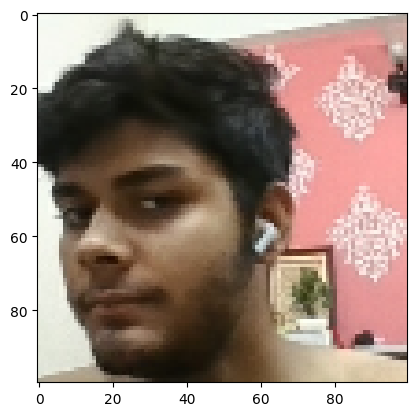

In [33]:
res = preprocess_twin(*example)
print(res[0])
plt.imshow(res[0])

tf.Tensor(
[[[0.95392156 0.9735294  0.9460784 ]
  [0.95686275 0.9764706  0.95      ]
  [0.95686275 0.9764706  0.9529412 ]
  ...
  [0.80441177 0.7941176  0.75808823]
  [0.717402   0.69534314 0.6622549 ]
  [0.6855392  0.6610294  0.6272059 ]]

 [[0.95490193 0.972549   0.94509804]
  [0.9588235  0.9764706  0.9490196 ]
  [0.9620098  0.9789216  0.9551471 ]
  ...
  [0.6995098  0.6622549  0.62034315]
  [0.7137255  0.6617647  0.6245098 ]
  [0.7051471  0.65       0.6110294 ]]

 [[0.9647059  0.9764706  0.9490196 ]
  [0.9647059  0.9764706  0.9490196 ]
  [0.9647059  0.9757353  0.9497549 ]
  ...
  [0.71642154 0.6392157  0.6014706 ]
  [0.7286765  0.64485294 0.60343134]
  [0.74191177 0.6497549  0.60808825]]

 ...

 [[0.8904412  0.89730394 0.84166664]
  [0.8659314  0.8727941  0.81715685]
  [0.84656864 0.847549   0.7916667 ]
  ...
  [0.8661765  0.79068625 0.6818628 ]
  [0.87083334 0.8012255  0.6968137 ]
  [0.87647057 0.8068628  0.70392156]]

 [[0.75784314 0.74607843 0.6727941 ]
  [0.7017157  0.6840686  0

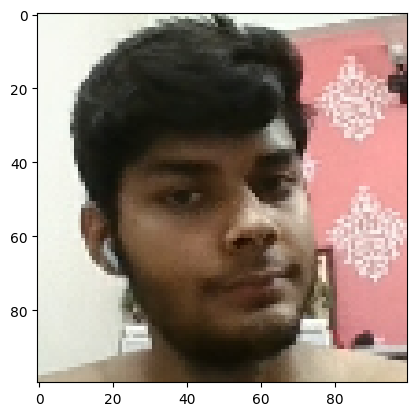

In [34]:
print(res[1])
plt.imshow(res[1])

In [35]:
print(res[2])

1.0


### Build Data Loader Pipeline

In [36]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [37]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

3


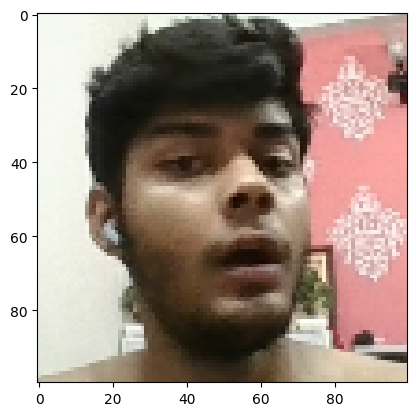

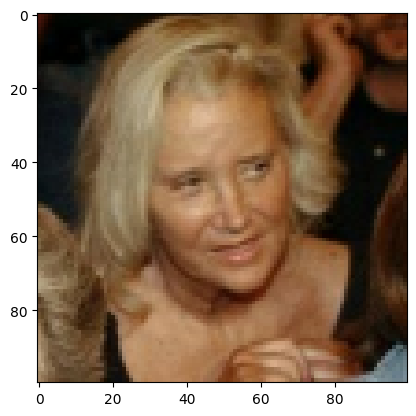

Label :  1.0


(array([[[0.96960783, 0.97745097, 0.9578431 ],
         [0.9620098 , 0.9757353 , 0.9482843 ],
         [0.95686275, 0.9764706 , 0.9490196 ],
         ...,
         [0.70612746, 0.67720586, 0.64656866],
         [0.6642157 , 0.62941176, 0.6017157 ],
         [0.6786765 , 0.6389706 , 0.6122549 ]],
 
        [[0.96544117, 0.9732843 , 0.95367646],
         [0.9615196 , 0.9732843 , 0.9458333 ],
         [0.9588235 , 0.9764706 , 0.9490196 ],
         ...,
         [0.70416665, 0.6522059 , 0.6161765 ],
         [0.70686275, 0.6504902 , 0.6139706 ],
         [0.7085784 , 0.6497549 , 0.61151963]],
 
        [[0.96838236, 0.9762255 , 0.95661765],
         [0.9637255 , 0.9754902 , 0.94803923],
         [0.9588235 , 0.9764706 , 0.9490196 ],
         ...,
         [0.7237745 , 0.6458333 , 0.6036765 ],
         [0.7355392 , 0.64730394, 0.60808825],
         [0.7509804 , 0.65      , 0.6127451 ]],
 
        ...,
 
        [[0.8654412 , 0.8784314 , 0.82598037],
         [0.87647057, 0.8833333 , 0.83137

In [38]:
samples = data.as_numpy_iterator()
print(len(samples.next()))
plt.imshow(samples.next()[0])
plt.show()
plt.imshow(samples.next()[1])
plt.show()
print("Label : ", samples.next()[2])
samples.next()

### Training Partition

In [39]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [40]:
print(round(len(data)*.7))
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(10)
train_data = train_data.prefetch(5)

420


In [41]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [42]:
train_samples = train_data.as_numpy_iterator()
print(len(train_samples.next()[0]))

10


### Testing Partiton

In [43]:
print(round(len(data)*.3))
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(10)
test_data = test_data.prefetch(5)

180


In [44]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

10


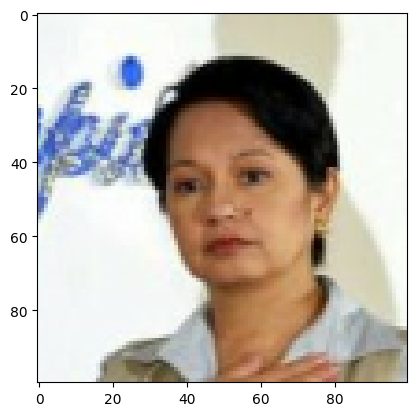

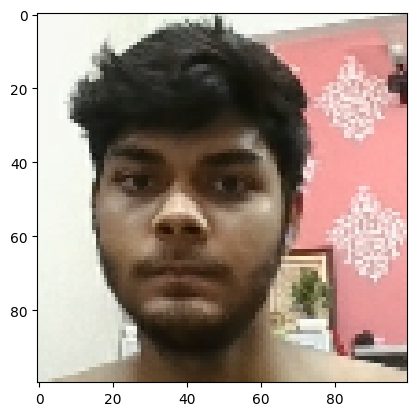

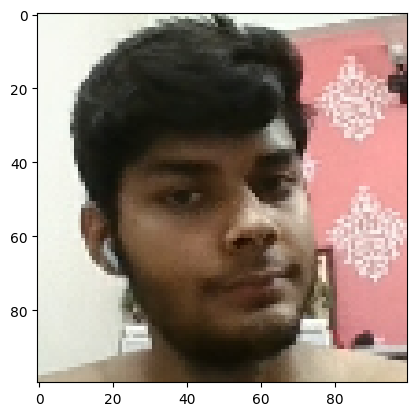

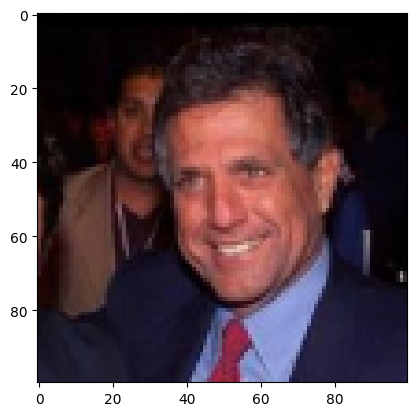

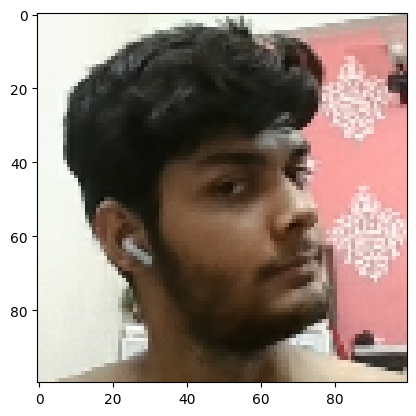

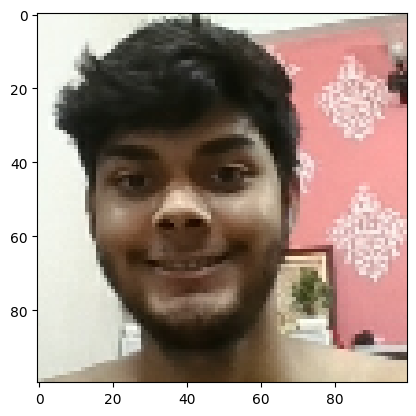

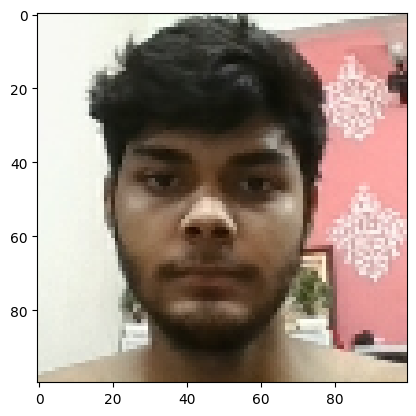

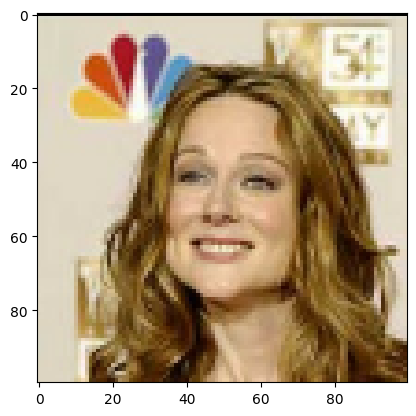

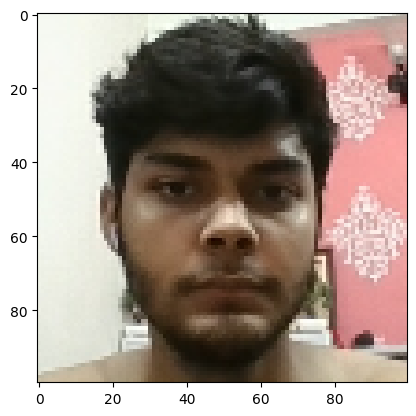

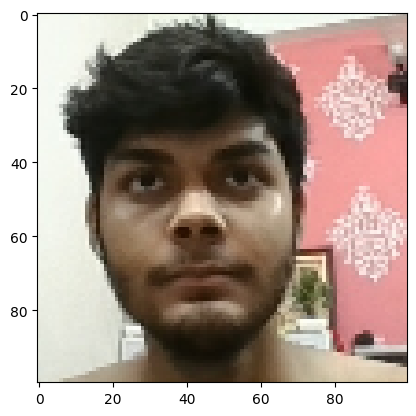

In [45]:
test_samples = test_data.as_numpy_iterator()
print(len(test_samples.next()[0]))
for img in test_samples.next()[1]:
    plt.imshow(img)
    plt.show()

### Build Embedding Layer

In [46]:
inp = Input(shape=(105, 105, 3), name='input_image')

In [47]:
inp

<KerasTensor: shape=(None, 105, 105, 3) dtype=float32 (created by layer 'input_image')>

In [48]:
def make_embedding():
    inp = Input(shape=(105, 105, 3), name='input_image')
    
#     First Block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    mp1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    
#     Second Block
    c2 = Conv2D(128, (7, 7), activation='relu')(mp1)
    mp2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    
#     Third Block
    c3 = Conv2D(128, (4, 4), activation='relu')(mp2)
    mp3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    
#     Final Embedding Block
    c4 = Conv2D(256, (4, 4), activation='relu')(mp3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [49]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

### Build Distance Layer

In [50]:
# Siamese L1 distance class
class L1dist(Layer):
    
#     Init method - Inheritance
    def __init__(self, **kwargs):
        super().__init__()
    
#     Similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [51]:
l1 = L1dist()

In [52]:
# l1(anchor_embedding, validation_embedding)

In [53]:
l1

### Make Siamese Model

In [54]:
def make_siamese_model():
    
#     Anchor image in the network
    input_image = Input(name='input_img', shape=(105, 105, 3))
    
#     Validation image in the network
    validation_image = Input(name='validation_img', shape=(105, 105, 3))
    
#     Combine siamese distance components
    siamese_layer = L1dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
#     Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='Siamese_Network')

In [55]:
Siamese_Model = make_siamese_model()
Siamese_Model.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0]

### Setup Loss and Optimizer

In [66]:
# Binary loss function
binary_loss = tf.losses.BinaryCrossentropy()

# Adam optimizer with 0.0001 learning rate
optimizer = tf.keras.optimizers.Adam(1e-4)

### Establish Checkpoints

In [61]:
# Make training_checkpoints directory in the main directory
CHECKPOINT_PATH = os.path.join('training_checkpoints')
os.makedirs(CHECKPOINT_PATH)

In [67]:
checkpoint_dir = './training_checkpoints/'

# Store the checkpoints as 'ckpt' file in training_checkpoints directory
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

# What the checkpoint should store in it?
checkpoint = tf.train.Checkpoint(optimizer=optimizer, Siamese_Model=Siamese_Model)

### Build Train Step Function

In [72]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
x = batch_1[:2]
y = batch_1[2]
x, y

((array([[[[0.9647059 , 0.972549  , 0.9529412 ],
           [0.96862745, 0.98039216, 0.9529412 ],
           [0.96862745, 0.98039216, 0.9529412 ],
           ...,
           [0.72843134, 0.7031863 , 0.6666667 ],
           [0.7004902 , 0.6730392 , 0.6401961 ],
           [0.68210787, 0.64681375, 0.61789215]],
  
          [[0.96862745, 0.98039216, 0.9529412 ],
           [0.96862745, 0.98039216, 0.9529412 ],
           [0.96862745, 0.98039216, 0.9529412 ],
           ...,
           [0.7053922 , 0.6637255 , 0.61691177],
           [0.702451  , 0.6504902 , 0.6112745 ],
           [0.71544117, 0.65661764, 0.61838233]],
  
          [[0.9647059 , 0.9764706 , 0.9490196 ],
           [0.964951  , 0.9767157 , 0.9433824 ],
           [0.96862745, 0.98039216, 0.9470588 ],
           ...,
           [0.73039216, 0.65612745, 0.60318625],
           [0.7272059 , 0.6389706 , 0.5919118 ],
           [0.7561275 , 0.6551471 , 0.6120098 ]],
  
          ...,
  
          [[0.8752451 , 0.8872549 , 0.83

In [ ]:
@tf.function
def train_steps(batch):
    
#     Record all operations
    with tf.GradientTape() as Tape:
#         Get anchor and positive/negative images
        X = batch[:2]
#         Get label
        Y = batch[2]
        
#         Forward pass
        Y_pred = Siamese_Model(X, training=True)
#         Calculate loss
        loss = binary_loss(Y, Y_pred)
        
    print(loss)
    
#     Calculate gradients
    grad = tape.gradient(loss, Siamese_Model.trainable_variables)
    
#     Calculate updated weights and apply it to siamese model
    optimizer.apply_gradients(zip(grad, Siamese_Model.trainable_variables))
    
    return loss

Object `gradient` not found.
